In [1]:
## This code chunk was hidden in the original document, but was executed in the background
knitr::opts_chunk$set(results="hide", message=FALSE, warning=FALSE, fig.show="hide", echo=TRUE)

<script type="text/javascript"
  src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>
<h1>
Cloud-enabled cis-eQTL searches with GGtools 4.10+
</h1>
-   [Background](#background-sec)
-   [Objectives](#objectives-sec)
    -   [Basic reporting](#reporting-sec)
    -   [Visualization](#viz-sec)
-   [Raw materials: structuring expression, genotype, and sample data](#rawdata-sec)
-   [Cluster management with starcluster](#starcluster-sec)
-   [Programming the parallel search: various strategies](#parallel-sec)
    -   [High-level, socket-based cluster: ciseqByCluster](#hilev-sec)
    -   [BatchJobs-based approach](#batj-sec)
-   [Working with the results](#results-sec)
    -   [Overview QQ-plot](#ovplot-sec)
    -   [Sensitivity analysis of tuning the search](#sens-sec)
    -   [Visualizing results for a gene](#gviz-sec)
    -   [Statistical characteristics of search results](#stats-sec)

In [2]:
## This code chunk was hidden in the original document, but was executed in the background
date()

[1] "Thu Jan  7 11:34:55 2016"

In [3]:
## This code chunk was hidden in the original document, but was executed in the background
scoresCis = function(...){NULL}  # does commented unevald code get checked?
suppressMessages({  # include some warnings on symbol replacements
if (!("GGdata" %in% installed.packages()[,1])) {
 source("http://www.bioconductor.org/biocLite.R")
 biocLite("GGdata")
}
if (!("SNPlocs.Hsapiens.dbSNP144.GRCh37" %in% installed.packages()[,1])) {
 source("http://www.bioconductor.org/biocLite.R")
 biocLite("SNPlocs.Hsapiens.dbSNP144.GRCh37")
}
library(knitcitations)
library(bibtex)
allbib = read.bibtex("allbib.bib")
library(GenomeInfoDb)
library(S4Vectors)
library(GGtools)
library(GGdata)
library(yri1kgv)
library(snpStats)
library(scatterplot3d)
library(lumi)
library(parallel)
library(foreach)
library(doParallel)
library(biglm)
library(lumiHumanAll.db)
library(rmeta)
library(SNPlocs.Hsapiens.dbSNP144.GRCh37)
if (!exists("partceu100k_dt")) load("partceu100k_dt.rda")
})

<h2 id="background-sec">
Background
</h2>
Numerous studies have employed genome-wide measures of mRNA abundance (typically assayed using DNA microarrays, and more recently RNA-seq) in combination with high-resolution genotyping (often supplemented with statistical imputation to loci not directly assayed, leading to genotype calls with quantified uncertainty) to search for genetic determinants of variation in gene expression. Key references in human applications include Cheung, Spielman, Ewens, Weber, Morley, and Burdick (2005), Majewski and Pastinen (2011), and Gaffney, Veyrieras, Degner, Pique-Regi, Pai, Crawford, Stephens, Gilad, and Pritchard (2012); Shabalin (2012) addresses computational concerns.

This document focuses on searches for eQTL <emph>in cis</emph>, so that DNA variants local to the gene assayed for expression are tested for association.

A typical report describes tuning of the search (including, for example, boundaries on minor allele frequencies of variants to be tested, approach to correction for batch effects and other forms of confounding, scope of search in terms of distance from gene coding region), enumerates variants with evidence of association to expression variation in nearby genes, and then characterizes the biological roles of the discovered variants.

N.B. The gQTLstats package will supersede GGtools for scalable eQTL analysis; look for a revised workflow 2016Q1.

<h2 id="objectives-sec">
Objectives
</h2>
Suppose there are \\(N\\) independently sampled individuals with gene expression measures on \\(G\\) genes or probes. Each individual is genotyped (or has genotype statistically imputed) at \\(S\\) DNA locations, catalogued by NCBI dbSNP or 1000 genomes. We are given a \\(G N\\) matrix of expression assay results, and \\(N S\\) genotyping results in the form of the number of B alleles (or expected number of B alleles) for each of the loci. Select the search radius \\(\\) (for example, 100kb) and for each gene \\(g\\), determine the search neighborhoods \\(N\_g = N\_{g,} = \[a\_g-, b\_g+\]\\), where \\(a\_g\\) denotes the genomic coordinate of the 5' end of the transcript region for gene \\(g\\), and \\(b\_g\\) is the coordinate at the 3' end. Let \\(|N\_g|\\) denote the number of SNP in that neighborhood. Key objectives are

-   For each gene, compute the \\(|N\_g|\\) test statistics measuring association of SNPs in \\(N\_g\\) with mean expression of gene \\(g\\);
-   Obtain a measure of statistical significance for each test statistic;
-   Support adjustment and assessment of sensitivity analysis of statistical tests (e.g., adjustment for batch effects, effects of filtering on gene expression variation or SNP minor allele frequency);
-   Provide the test results in a format for ready interrogation using various types of search key;
-   Support visualization of associations at various scales.

<h3 id="reporting-sec">
Basic execution/reporting structure
</h3>
The code in the example for the GGtools function All.cis() yields an example of a sharply restricted search for cis eQTL on chr21, using data on the HapMap CEU population.

In [4]:
## This code chunk was hidden in the original document, but was executed in the background
   cc = new("CisConfig")
   chrnames(cc) = "21"
   lkp = try(library(parallel))
   if (!inherits(lkp, "try-error")) {
      nc = max(c(1,min(c(10, detectCores()-1))))
      options(mc.cores=nc)
      geneApply(cc) = mclapply
      }
   estimates(cc) = FALSE
   set.seed(1234)
   f1 <- All.cis( cc )  # devel: cisScores

get data...build map...

Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, : there is no package called ‘SNPlocs.Hsapiens.dbSNP.20120608’Warning message:
:   SNPlocs.Hsapiens.dbSNP144.GRCh37::getSNPlocs() is deprecated. Please use
      snps <- SNPlocs.Hsapiens.dbSNP144.GRCh37
      snplocs(snps, ...)
  instead. See '?snplocs' for more information.NOTE: expanding gene ranges by radius 50000 leads to negative start positions that are reset to 1.


run smFilter...filter probes in map...tests...get data...build map...

Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, : there is no package called ‘SNPlocs.Hsapiens.dbSNP.20120608’Warning message:
:   SNPlocs.Hsapiens.dbSNP144.GRCh37::getSNPlocs() is deprecated. Please use
      snps <- SNPlocs.Hsapiens.dbSNP144.GRCh37
      snplocs(snps, ...)
  instead. See '?snplocs' for more information.

run smFilter...filter probes in map...tests...get data...build map...

Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, : there is no package called ‘SNPlocs.Hsapiens.dbSNP.20120608’Warning message:
:   SNPlocs.Hsapiens.dbSNP144.GRCh37::getSNPlocs() is deprecated. Please use
      snps <- SNPlocs.Hsapiens.dbSNP144.GRCh37
      snplocs(snps, ...)
  instead. See '?snplocs' for more information.

run smFilter...filter probes in map...tests...get data...build map...

Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, : there is no package called ‘SNPlocs.Hsapiens.dbSNP.20120608’Warning message:
:   SNPlocs.Hsapiens.dbSNP144.GRCh37::getSNPlocs() is deprecated. Please use
      snps <- SNPlocs.Hsapiens.dbSNP144.GRCh37
      snplocs(snps, ...)
  instead. See '?snplocs' for more information.

run smFilter...filter probes in map...tests...

``` r
cc = new("CisConfig") # take a default configuration
chrnames(cc) = "21"   # confine to chr21
estimates(cc) = FALSE # no point estimates neede
f1 <- All.cis( cc )   # compute the tests; can be slow without attendance
                      # to parallelization
```

The result of the function inherits from GRanges, and includes metadata concerning its generation.

In [5]:
#ECHO=TRUE
length(f1)
f1[1:3]
metadata(f1)

[1] 6100

cisRun object with 3 ranges and 13 metadata columns:
                seqnames               ranges strand |         snp   snplocs
                   <Rle>            <IRanges>  <Rle> | <character> <integer>
  GI_11342663-S    chr21 [42683949, 42830869]      + |   rs2838008  42685044
  GI_11342663-S    chr21 [42683949, 42830869]      + |   rs9985079  42687136
  GI_11342663-S    chr21 [42683949, 42830869]      + |  rs12627067  42689443
                    score       fdr       probeid       MAF  dist.mid   mindist
                <numeric> <numeric>   <character> <numeric> <numeric> <numeric>
  GI_11342663-S      0.44 0.8442225 GI_11342663-S 0.3483146    -72365     48905
  GI_11342663-S      0.40 0.8569976 GI_11342663-S 0.4155844    -70273     46813
  GI_11342663-S      0.21 0.8948103 GI_11342663-S 0.2696629    -67966     44506
                genestart   geneend permScore_1 permScore_2 permScore_3
                <integer> <integer>   <numeric>   <numeric>   <numeric>
  GI_11342663-S  4

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$call
All.cis(config = cc)

$config
CisConfig instance; genome  hg19 .  Key parameters:
smpack =  GGdata ; chrnames =  21 
nperm =  3 ; radius =  50000 
====
Configure using 
 [1] "smpack<-"        "rhs<-"           "nperm<-"         "folderStem<-"   
 [5] "radius<-"        "shortfac<-"      "chrnames<-"      "smchrpref<-"    
 [9] "gchrpref<-"      "schrpref<-"      "geneApply<-"     "geneannopk<-"   
[13] "snpannopk<-"     "smFilter<-"      "exFilter<-"      "keepMapCache<-" 
[17] "SSgen<-"         "genome<-"        "excludeRadius<-" "estimates<-"    
[21] "extraProps<-"    "useME<-"         "MEpvot<-"       


Use of GRanges for the organization of association test statistics allows easy amalgamation of findings with other forms of genomic annotation. Retention of the association scores achieved under permutation allows recomputation of plug-in FDR after combination or filtering.

<h3 id="viz=sec">
Visualization examples
</h3>
Targeted visualization of association is supported with the plot\_EvG function in GGBase. To obtain the figure on the right, the expression matrix has been transformed by removing the principal components corresponding to the 10 largest eigenvalues. This is a crude approach to reducing \`\`expression heterogeneity'', a main concern of eQTL analyses to date (Leek and Storey, 2007).

In [6]:
## setting Jupyter plotting size
options(repr.plot.width=7,repr.plot.height=4)

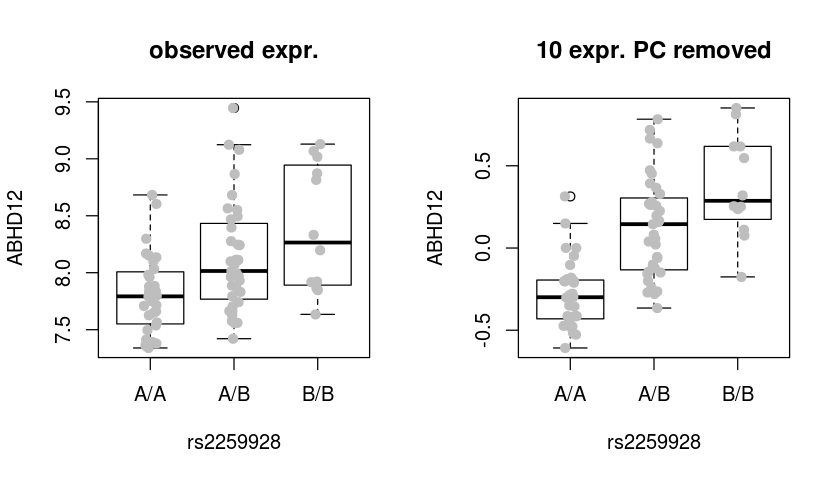

In [7]:
## This code chunk was hidden in the original document, but was executed in the background
suppressMessages({
library(yri1kgv)
if (!exists("c20")) c20 = getSS("yri1kgv", "chr20")
par(mfrow=c(1,2))
plot_EvG(probeId("o67h4JQSuEa02CJJIQ"), rsid("rs2259928"), c20,
  main="observed expr.")
if (!exists("c20f")) c20f = clipPCs(c20, 1:10)
plot_EvG(probeId("o67h4JQSuEa02CJJIQ"), rsid("rs2259928"), c20f,
  main="10 expr. PC removed")
})

``` r
plot_EvG(probeId("o67h4JQSuEa02CJJIQ"), rsid("rs2259928"), c20f,
  main="10 expr. PC removed")
```

Above we have a single SNP-gene association.
The family of associations observed cis to ABHD12 can also be visualized in conjunction with the transcript models.

<img src="abhd12.png">

<h2 id="rawdata-sec">
Raw materials: structuring expression, genotype, and sample data
</h2>
<h3 id="SnpMatrix-sec">
SnpMatrix from snpStats for called and imputed genotypes
</h3>
As of November 2013, a reasonably efficient representation of expression, sample and genotype data is defined using an R package containing

-   an ExpressionSet instance, and
-   a folder inst/parts containing genotype data as SnpMatrix instances, as defined in the snpStats package.

Elements of the sampleNames of the ExpressionSet instance must coincide with elements of the row names of the SnpMatrix instances. At time of analysis, warnings will be issued and harmonization attempts will be made when the coincidence is not exact.

The SnpMatrix instances make use of a byte code for (potentially) imputed genotypes. Each element of the code defines a point on the simplex displayed below, allowing a discrete but rich set of the key quantities of interest, the expected number of B alleles.

In [8]:
## setting Jupyter plotting size
options(repr.plot.width=4,repr.plot.height=4)

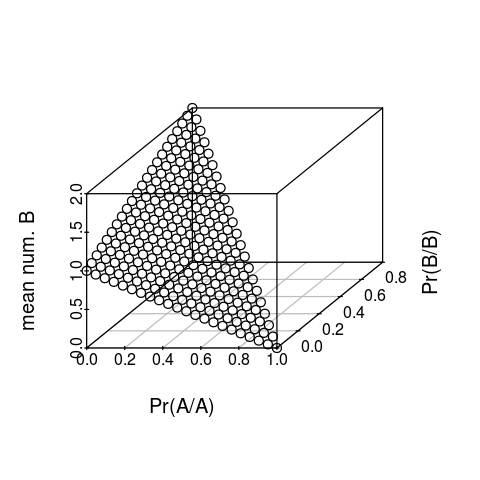

In [9]:
## This code chunk was hidden in the original document, but was executed in the background
library(snpStats)
library(scatterplot3d)
tmp = as.raw(1:253)
yy = g2post(tmp)
EB = yy %*% c(0,1,2) 
scatterplot3d(yy[,1], yy[,3], EB, xlab="Pr(A/A)", ylab="Pr(B/B)", zlab="mean num. B")

Note that the nucleotide codes are not carried in this representation. Typically for a diallelic SNP, B denotes the alphabetically later nucleotide.

<h3 id="smlSet-sec">
smlSet for coordinating genotype, expression, and sample-level data
</h3>
We can illustrate the basic operations with this overall structure, using data collected on Yoruban (YRI) HapMap cell lines. Expression data were obtained at ArrayExpression E-MTAB-264 (Stranger, Montgomery, Dimas, Parts, Stegle, Ingle, Sekowska, Smith, Evans, Gutierrez-Arcelus, Price, Raj, Nisbett, Nica, Beazley, Durbin, Deloukas, and Dermitzakis, 2012).

In [10]:
library(GGtools)
library(yri1kgv)
library(lumiHumanAll.db)
if (!exists("y22")) y22 = getSS("yri1kgv", "chr22")
y22
dim(exprs(y22))
fn = featureNames(y22)[1:5]

harmonizeSamples TRUE and sampleNames for es not coincident with rownames(sml[[1]]); harmonizing...[not a warning]


SnpMatrix-based genotype set:
number of samples:  79 
number of chromosomes present:  1 
annotation: lumiHumanAll.db 
Expression data dims: 21800 x 79 
Total number of SNP: 494322 
Phenodata: An object of class 'AnnotatedDataFrame'
  sampleNames: NA18486 NA18487 ... NA19257 (79 total)
  varLabels: Source.Name Material.Type ... Factor.Value.SIGNAL. (26
    total)
  varMetadata: labelDescription

[1] 21800    79

The annotation of expression features can be explored in several directions. First, the probe names themselves encode the 50mers on the chip.

In [11]:
library(lumi)
id2seq(fn) # get the 50mer for each probe
# and some annotation

NQqs8dKRwVSgI4SRPk 
"CAAGGGGTATTACTCAGGCACTAACCCCAGGAAAGATGACAGCACATTGC" 
                                  BvIpQQ9yzp__kCLnEU 
"GTTAGAGGCCAACAATTCTAGTATGGCTTGTTGGCAAAGAGTGCTACACC" 
                                  NH1MoTHk7CULTog3nk 
"ACTTCCATAGGACATACTGCATGTAAGCCAAGTCATGGAGAATCTGCTGC" 
                                  KNJlVFShMX1UoyIkRc 
"ATCAGCGCCCCCACCCAGGACATACCTTCCCCAGGATAGAGAGCACACCT" 
                                  fuplG2R3erO3QrujDk 
"GTGGGCGCCACGTCGCACTCTCTGGGTATGTCTCAAGGTGTGGATAATGC"

Second, the mapping to institutionally curated gene identifiers is available.

In [12]:
select( lumiHumanAll.db, keys=fn, keytype="PROBEID", columns=c("SYMBOL", "CHR", "ENTREZID"))

Warning message:
In .deprecatedColsMessage(): Accessing gene location information via 'CHR','CHRLOC','CHRLOCEND' is
  deprecated. Please use a range based accessor like genes(), or select()
  with columns values like TXCHROM and TXSTART on a TxDb or OrganismDb
  object instead.'select()' returned 1:1 mapping between keys and columns


,PROBEID,SYMBOL,CHR,ENTREZID
1,NQqs8dKRwVSgI4SRPk,THBS3,1,7059
2,BvIpQQ9yzp__kCLnEU,SLC38A2,12,54407
3,NH1MoTHk7CULTog3nk,CCNB1,5,891
4,KNJlVFShMX1UoyIkRc,ZNF496,1,84838
5,fuplG2R3erO3QrujDk,LOC100130238,12,100130238


Finally, we can look at the genotype information. This can be voluminous and is managed in an environment to reduce potential copying expenses.

In [13]:
gt22 <- smList(y22)[[1]]  # access to genotypes
as( gt22[1:5,1:5], "character" )
cs22 = col.summary(gt22)  # some information on genotypes
cs22[1:10,]

,rs149201999,rs146752890,rs139377059,rs188945759,rs6518357
NA18486,A/A,A/A,A/A,A/A,A/A
NA18487,A/A,A/A,A/A,A/A,A/A
NA18489,A/A,A/A,A/A,A/A,A/A
NA18498,A/A,A/A,A/A,A/A,A/A
NA18499,A/A,A/A,A/A,A/A,A/A


,Calls,Call.rate,Certain.calls,RAF,MAF,P.AA,P.AB,P.BB,z.HWE
rs149201999,79,1,1,0.09493671,0.09493671,0.8101266,0.1898734,0,0.9323281
rs146752890,79,1,1,0.06962025,0.06962025,0.8607595,0.1392405,0,0.665103
rs139377059,79,1,1,0.06962025,0.06962025,0.8607595,0.1392405,0,0.665103
rs188945759,79,1,1,0.006329114,0.006329114,0.9873418,0.01265823,0,0.0566127
rs6518357,79,1,1,0.07594937,0.07594937,0.8481013,0.1518987,0,0.7305365
rs62224609,79,1,1,0,0,1,0,0,NA
rs62224610,79,1,1,0.2974684,0.2974684,0.4936709,0.4177215,0.08860759,-0.005111095
rs143503259,79,1,1,0,0,1,0,0,NA
rs192339082,79,1,1,0,0,1,0,0,NA
rs79725552,79,1,1,0.07594937,0.07594937,0.8481013,0.1518987,0,0.7305365


<h2 id="starcluster-sec">
Cluster management with starcluster
</h2>
This workflow is based on Amazon EC2 computation managed using the [MIT starcluster utilities](http://star.mit.edu/cluster/). Configuration and management of EC2 based machinery is quite simple. The bulk of the partial run described here used configuration variables

-   CLUSTER\_SIZE = 4
-   NODE\_IMAGE\_ID = ami-bdaa99d4
-   NODE\_INSTANCE\_TYPE = c3.2xlarge \# 8 cores, 15GB RAM on each
-   MASTER\_INSTANCE\_TYPE = c3.2xlarge

In a complete run, for chromosome 1, a rescue run was required with a larger instance type (m3.2xlarge).

<h2 id="parallel-sec">
Programming the parallelized search: various approaches
</h2>
<h3 id="hilev-sec">
High-level, socket-based cluster: ciseqByCluster
</h3>
We will describe an essentially monolithic approach to using a cluster to search for eQTL in which evaluation of a single R function drives the search. The master process will communicate with slaves via sockets; slaves will write results to disk and ship back to master. The task is executed across chromosomes that have been split roughly in thirds to reduce RAM consumption.

The ciseqByCluster function of GGtools is the workhorse for the search. Arguments to this function determine how the search will be configured and executed. The invocation here asks for a search on four chromosomes, dispatching work from a master R process to a four node cluster, with multicore concurrency for gene-specific searches on eight cores per node. Three output files are generated in the folder identified as targetfolder:

-   an RDA file serializing a data.table instance with a record for each SNP-probe pair satisfying the cis proximity criterion
-   a tabix-indexed GFF3 file with the same information as the data.table
-   the tabix .tbi file for the GFF3

The following script is available on the AMI noted above and will generate the partceu100k\_dt data.table instance used for analysis below.

``` r
library(parallel)
newcl = makePSOCKcluster(c("master", paste0("node00", 1:3)))
library(foreach)
library(doParallel)
registerDoParallel(cores=8)  # may want to keep at 5

library(GGtools)
ceuDemoRecov = try(ciseqByCluster( newcl, 
   chromsToRun=19:22, finaltag="partceu100k",
   outprefix="ceurun",
   ncoresPerNode=8, targetfolder="/freshdata/CEU_DEMO"  ))
save(ceuDemoRecov, file="ceuDemoRecov.rda")
stopCluster(newcl)
stopImplicitCluster()
sessionInfo()
```

The full set of arguments and defaults for ciseqByCluster is

-   pack = "yri1kgv",
-   outprefix = "yrirun",
-   chromsToRun = 1:22, \# if length is C will use 3C nodes
-   targetfolder = "/freshdata/YRI\_3", \# for demo, a volume reference
-   radius = 100000L,
-   nperm = 3L,
-   numNodes = 8,
-   nodeNames = rep("localhost", numNodes),
-   ncoresPerNode = 8,
-   numPCtoFilter = 10,
-   lowerMAF = .02,
-   geneannopk = "lumiHumanAll.db",
-   snpannopk = "SNPlocs.Hsapiens.dbSNP144.GRCh37"
-   smchrpref = "chr"

The GFF3 file that is generated along with the data.table instance is useful for targeted queries, potentially from external applications. The primary difficulty with using this in R is the need to parse the optional data subfields of field 9.

<h2 id="results-sec">
Working with the results
</h2>
<h3 id="ovplot-sec">
Overview QQ-plot
</h3>
It is customary to inspect QQ-plots for genome-wide association studies. For eQTL searches, the number of test results can range into the billions, so a binned approach is taken.

``` r
binnedQQ(partceu100k_dt, ylim=c(0,30), xlim=c(-2,15), end45=12)
```

<img src="lkqq.png">

This gives an indication that the distribution of the vast majority of observed SNP-gene pair association statistics is consistent with the null model.

<h3 id="sens-sec">
Sensitivity analysis of tuning the search
</h3>
Because our data.table output retains information on association scores achieved after permuting expression against genotype, we can recompute plug-in FDRs for loci that remain after filtering the full set of records in various ways. The eqsens\_dt function allows exploration of sensitivity of eQTL enumerations across various dimensions, and users can add additional dimension through suitable programming. The default behavior is illustrated first:

In [14]:
## This code chunk was hidden in the original document, but was executed in the background
update_fdr_filt = function (tab, filt = function(x) x, by = c("pairs", "snps", 
    "probes")[1]) {
    require(GGtools, quietly = TRUE)
    tab = filt(tab)
    psinds = grep("permScore", colnames(tab), value = TRUE)
    nr = nrow(tab)
    pscores = vector("numeric", nr * length(psinds))
    for (np in 1:length(psinds)) pscores[(((np - 1) * nr) + 1):(np * 
        nr)] = tab[[psinds[np]]]
    if (by == "pairs") {
        newfd = pifdr(tab$score, pscores)
    }
    else {
        if (by == "snps") 
            byvar = "snp"
        else if (by == "probes") 
            byvar = "probeid"
        base = tab[, max(score), by = byvar]
        maxbysnp = base$V1
        ol = list()
        pnames = grep("permScore", names(tab))
        for (i in 1:length(pnames)) {
            tab$score = tab[, pnames[i], with = FALSE]
            ol[[i]] = tab[, max(score), by = byvar]$V1
        }
        newfd = pifdr(maxbysnp, as.numeric(unlist(ol)))
        tab = base
    }
    tab$fdr = newfd
    tab
}

#
# defining here so that release version can be used
#
filtgen.maf.dist = function (maf.dist, 
     validate.tab = function(tab) all(c("mindist", 
    "MAF") %in% colnames(tab))) 
{
    stopifnot(is.atomic(maf.dist))
    stopifnot(length(maf.dist) == 2)
    maf = maf.dist[1]
    dist = maf.dist[2]
    function(tab) {
        stopifnot(isTRUE(validate.tab(tab)))
        tab[tab$mindist <= dist & tab$MAF >= maf, ]
    }
}

eqsens_dt = function (dtab, filtgen = filtgen.maf.dist, by = c("pairs", "snps", 
    "probes")[1], targfdrs = c(0.05, 0.01, 0.005), parmslist = list(mafs = c(0.025, 
    0.05, 0.075, 0.1, 0.125), dists = c(1000, 5000, 10000, 25000, 
    50000, 1e+05))) 
{
    parmset = data.matrix(do.call(expand.grid, parmslist))
    ntune = nrow(parmset)
    ans = foreach(curp = 1:ntune) %dopar% {
        tmp = update_fdr_filt(tab = dtab, filt = filtgen(parmset[curp, 
            ]), by = by)
        sapply(targfdrs, function(x) sum(tmp$fdr <= x))
    }
    hold = t(sapply(ans, force))
    colnames(hold) = paste0("at_", targfdrs)
    cbind(parmset, hold)
}
filtgen.maf.dist = function (maf.dist, validate.tab = function(tab) all(c("mindist", 
    "MAF") %in% colnames(tab))) 
{
    stopifnot(is.atomic(maf.dist))
    stopifnot(length(maf.dist) == 2)
    maf = maf.dist[1]
    dist = maf.dist[2]
    function(tab) {
        stopifnot(isTRUE(validate.tab(tab)))
        tab[tab$mindist <= dist & tab$MAF >= maf, ]
    }
}
plotsens = function (eqsout, ylab = "count of eQTL at given FDR", 
    title = "cis radius in bp") {
    require(reshape2)
    require(ggplot2)
    mdf = melt(data.frame(eqsout), id.vars = c("mafs", "dists"))
    vind = which(names(mdf) == "variable")
    names(mdf)[vind] = "FDR"
    mdf[, vind] = gsub("at_", "", mdf[, vind])
    ggplot(data = mdf) + geom_point(aes(x = mafs, y = value, 
        colour = FDR)) + facet_grid(~dists) + theme(axis.text.x = element_text(angle = 90)) + 
        ylab(ylab) + labs(title = title)
}

In [15]:
load("partceu100k_dt.rda")
library(foreach)  # basic function includes a %dopar%
library(doParallel)
library(parallel)
# dcdown = max(c(detectCores()-1,1)) ## use with lots of RAM
dcdown = 1
registerDoSEQ()
if (.Platform$OS.type != "windows") {
 #cl = makeForkCluster(dcdown)
 registerDoParallel(cores=dcdown) # nesting?
 }

``` r
eq1 = eqsens_dt(partceu100k_dt)
```

In [16]:
## This code chunk was hidden in the original document, but was executed in the background
load("sensSave.rda")
eq1 = sensSave

plotsens(eq1) \`\`\`

The arguments to eqsens\_dt are

In [17]:
args(eqsens_dt)

function (dtab, filtgen = filtgen.maf.dist, by = c("pairs", "snps", 
    "probes")[1], targfdrs = c(0.05, 0.01, 0.005), parmslist = list(mafs = c(0.025, 
    0.05, 0.075, 0.1, 0.125), dists = c(1000, 5000, 10000, 25000, 
    50000, 1e+05))) 
NULL

and setting components of the parmslist argument governs the set of tuning parameter vectors that will be used. Exploration of additional dimensions would involve passing a different function for the filtgen parameter; filtgen.maf.dist assumes a 2-vector of (MAF, dist) will be used to retain rows with MAF exceeding the input MAF, and dist no greater than the input mindist from SNP to gene.

<h3 id="gviz-sec">
Visualizing results for a gene
</h3>
As of 1/20/2014 the call to scoresCis() can only be executed with R-devel and GGtools 4.11.28+.

We will focus on the data.table output. A basic objective is targeted visualization. The scoresCis function helps with this. We load the data.table instance first.

``` r
library(data.table)
load("partceu100k_dt.rda")
scoresCis("CPNE1", partceu100k_dt)
```

<!-- some code dropped here -->
<img src="demomod.png">

<h3 id="stats-sec">
Statistical characteristics of search results
</h3>
In this section we consider how structural and genetic information can be used to distinguish conditional probabilities of SNP genotypes being associated with phenotypic variation. We use some additional data provided in the GGtools package concerning a) chromatin state of the lymphoblastoid cell line GM12878, a line similar to those form which expression data were generated, and b) identities of SNP that have been found to be hits or are in LD with hits at \\( R^2 &gt; 0.80 \\) in the NHGRI GWAS catalog. See man pages for hmm878 in GGtools package and gwastagger in gwascat package for more information. These data are automatically propagated to ciseqByCluster data.table output.

Our approach is to use logistic regression on 1.5 million records. We use the biglm package to keep memory images modest.

We discretize some of the key factors, and form an indicator variable for the event that the SNP is in a region of active or poised promoter chromatin state, as determined by ChromHMM on GM12878.

In [18]:
distcat = cut(partceu100k_dt$mindist,c(-1, 1, 1000, 5000, 10000, 50000, 100001))
fdrcat = cut(partceu100k_dt$fdr,c(-.01,.005, .05, .1, .2, 1.01))
fdrcat = relevel(fdrcat, "(0.2,1.01]")
mafcat = cut(partceu100k_dt$MAF,c(0,.05, .1, .2, .3, .51))
approm = 1*partceu100k_dt$chromcat878 %in% c("1_Active_Promoter", "3_Poised_Promoter")

Now we rebuild the data.table and fit the model to a randomly selected training set of about half the total number of records.

In [19]:
partceu100k_dt = cbind(partceu100k_dt, distcat, fdrcat, mafcat, approm)
set.seed(1234)
train = sample(1:nrow(partceu100k_dt), 
   size=floor(nrow(partceu100k_dt)/2), replace=FALSE)
library(biglm)
b1 = bigglm(isgwashit~distcat+fdrcat+mafcat+approm, fam=binomial(),
 data=partceu100k_dt[train,], maxit=30)

A source of figures of merit is the calibration of predictions against actual hit events in the test set.

In [20]:
pp = predict(b1, newdata=partceu100k_dt[-train,], type="response")
summary(pp)
cpp = cut(pp, c(0,.025, .05, .12, .21))
table(cpp)
sapply(split(partceu100k_dt$isgwashit[-train], cpp), mean)

       V1          
 Min.   :0.002408  
 1st Qu.:0.006612  
 Median :0.016698  
 Mean   :0.015935  
 3rd Qu.:0.027334  
 Max.   :0.200049  

cpp
   (0,0.025] (0.025,0.05]  (0.05,0.12]  (0.12,0.21] 
     1026788       467427         1701         1473 

(0,0.025] (0.025,0.05]  (0.05,0.12]  (0.12,0.21] 
 0.009177162  0.030655054  0.061140506  0.158859470

It seems that the model, fit using data on a small number of chromosomes, has some predictive utility. We can visualize the coefficients:

In [21]:
## setting Jupyter plotting size
options(repr.plot.width=7,repr.plot.height=4)

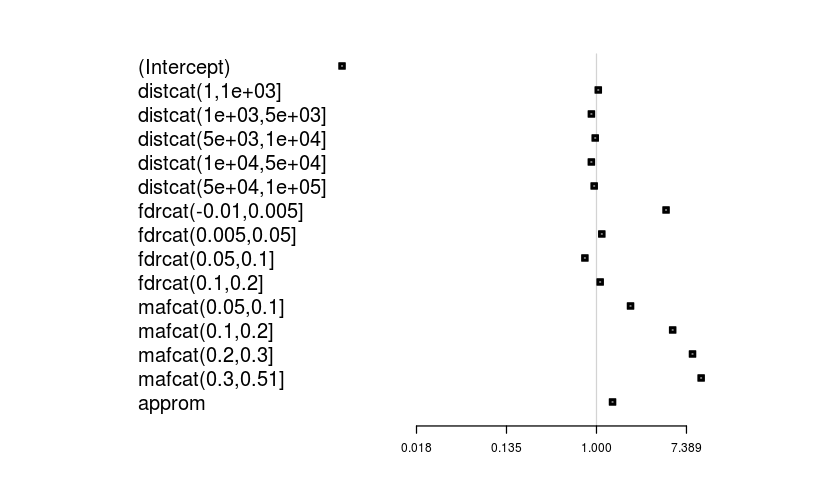

In [22]:
tmat = matrix(rownames(summary(b1)$mat),nc=1)
est = summary(b1)$mat[,1]
library(rmeta)
forestplot(tmat, est, est-.01, est+.01, xlog=TRUE,
  boxsize=.35, graphwidth=unit(3, "inches"),
  xticks=exp(seq(-4,2,2)))

Standard errors in the presence of correlations among responses require further methodological development.

<h2 id="bib-sec">
References
</h2>

In [23]:
## This code chunk was hidden in the original document, but was executed in the background
bibliography() #style="markdown")

\[1\] V. G. Cheung, R. S. Spielman, K. G. Ewens, et al. "Mapping determinants of human gene expression by regional and genome-wide association". Eng. In: *Nature* 437.7063 (Oct. 2005), pp. 1365-9. DOI: 10.1038/nature04244.

\[2\] D. J. Gaffney, J. Veyrieras, J. F. Degner, et al. "Dissecting the regulatory architecture of gene expression QTLs". Eng. In: *Genome Biol* 13.1 (Jan. 2012), p. R7. DOI: 10.1186/gb-2012-13-1-r7. &lt;URL: <http://genomebiology.com/content/13/1/R7>&gt;.

\[3\] J. T. Leek and J. D. Storey. "Capturing heterogeneity in gene expression studies by surrogate variable analysis". Eng. In: *PLoS Genet* 3.9 (Sep. 2007), pp. 1724-35. DOI: 10.1371/journal.pgen.0030161. &lt;URL: <http://www.plosgenetics.org/article/info%253Adoi%252F10.1371%252Fjournal.pgen.0030161>}.&gt;

\[4\] J. Majewski and T. Pastinen. "The study of eQTL variations by RNA-seq: from SNPs to phenotypes". Eng. In: *Trends Genet* 27.2 (Feb. 2011), pp. 72-9. DOI: 10.1016/j.tig.2010.10.006.

\[5\] A. A. Shabalin. "Matrix eQTL: ultra fast eQTL analysis via large matrix operations". Eng. In: *Bioinformatics (Oxford, England)* 28.10 (May. 2012), pp. 1353-8. DOI: 10.1093/bioinformatics/bts163. &lt;URL: <http://bioinformatics.oxfordjournals.org/content/28/10/1353.long>&gt;.

\[6\] B. E. Stranger, S. B. Montgomery, A. S. Dimas, et al. "Patterns of cis regulatory variation in diverse human populations". Eng. In: *PLoS Genet* 8.4 (Jan. 2012), p. e1002639. DOI: 10.1371/journal.pgen.1002639.

In [24]:
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] SNPlocs.Hsapiens.dbSNP144.GRCh37_0.99.11
 [2] BSgenome_1.38.0                         
 [3] rtracklayer_1.30.1                      
 [4] Biostrings_2.38.2                       
 [5] XVector_0.10.0                          
 [6] GenomicRanges_1.22.2                    
 [7] rmeta_2.16                              
 [8] lumiHumanAll.db_1.22.0                  
 [9] b